This code is based on youtube video: https://www.youtube.com/watch?v=hlv79rcHws0

# Install used packages

In [1]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*
# Install virtual video device in colab
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

# Check the virtual video device is available
!echo $DISPLAY
!pip install utils

!pip install gymnasium
!pip install "gymnasium[all]"
!pip install mujoco==2.3.3
!pip install tensorboard

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-xkb-utils
  xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-utils
  x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 13 not upgraded.
Need to get 7,920 kB of archives.
After this operation, 12.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfontenc1 amd64 1:1.1.4-0ubuntu1 [14.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libxfont2 amd64 1:2.0.3-1 [91.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libxkbfile1 amd64 1:1.1.0-1 [65.3 kB]
Get:4 http://archive.ubuntu.com/ubuntu f

# Import packages

In [2]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

# Replay memory


In [3]:
class PPOMemory:
  def __init__(self, batch_size):
    self.states = []
    self.probs = []
    self.vals = []
    self.actions = []
    self.rewards = []
    self.dones = []
    self.entropy = []
    self.batch_size = batch_size

  def generate_batches(self):
    n_states = len(self.states)
    batch_start = np.arange(0, n_states, self.batch_size)
    indices = np.arange(n_states, dtype=np.int64)
    np.random.shuffle(indices)
    batches = [indices[i:i+self.batch_size] for i in batch_start]

    return np.array(self.states),\
        np.array(self.actions),\
        np.array(self.probs),\
        np.array(self.vals),\
        np.array(self.rewards),\
        np.array(self.dones),\
        np.array(self.entropy),\
        batches

  def store_memory(self, state, action, probs, vals, reward, done, entropy):
    self.states.append(state)
    self.actions.append(action)
    self.probs.append(probs)
    self.vals.append(vals)
    self.rewards.append(reward)
    self.dones.append(done)
    self.entropy.append(entropy)

  def clear_memory(self):
    self.states = []
    self.probs = []
    self.vals = []
    self.actions = []
    self.rewards = []
    self.dones = []
    self.entropy = []

# Actor Network


In [9]:
class actorNetwork(nn.Module):
  def __init__(self, input_dims, learning_rate, fc1_dims=128, fc2_dims=64, chkpt_dir='ppo'):
    super(actorNetwork, self).__init__()

    self.checkPoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')

    self.actor = nn.Sequential(
        self.layer_init(nn.Linear(*input_dims, fc1_dims)),
        nn.Tanh(),
        self.layer_init(nn.Linear(fc1_dims, fc2_dims)),
        nn.Tanh(),
        self.layer_init(nn.Linear(fc2_dims, 1), std=0.01),
    )

    self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate, eps=1e-5)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)
    self.sigma = nn.Parameter(T.zeros(1, 1))

  def layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer


  def forward(self, state):
    state = T.nn.functional.normalize(state)
    mu = self.actor(state)

    # Using radio to align sigma and mu
    log_sigma = self.sigma.to(self.device) + T.zeros_like(mu)
    sigma = T.exp(log_sigma)

    return mu, sigma

  def save_checkpoint(self):
    T.save(self.state_dict(), self.checkPoint_file)

  def load_checkpoint(self):
    self.load_state_dict(T.load(self.checkpoint_file))

# Critic network

In [5]:
class criticNetwork(nn.Module):
  def __init__(self, input_dims, learning_rate, fc1_dims=128, fc2_dims=64, chkpt_dir='ppo'):
    super(criticNetwork, self).__init__()

    self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
    self.critic = nn.Sequential(
        self.layer_init(nn.Linear(*input_dims, fc1_dims)),
        nn.Tanh(),
        self.layer_init(nn.Linear(fc1_dims, fc2_dims)),
        nn.Tanh(),
        self.layer_init(nn.Linear(fc2_dims, 1), std=1.0),
    )

    self.optimizer = optim.Adam(self.critic.parameters(), lr=learning_rate, eps=1e-5)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

  def forward(self, state):
    value = self.critic(state)

    return value

  def save_checkpoint(self):
    T.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
    self.load_state_dict(T.load(self.checkpoint_file))

# Agent

In [21]:
from torch.distributions import independent
class Agent:
  def __init__(self, input_dims, gamma=0.99, learning_rate=3e-4, gae_lambda=0.95, policy_clip=0.2, batch_size=64, N=2048, n_epochs=10):
    self.gamma = gamma
    self.policy_clip = policy_clip
    self.n_epochs = n_epochs
    self.gea_lambda = gae_lambda

    self.actor = actorNetwork(input_dims, learning_rate)
    self.critic = criticNetwork(input_dims, learning_rate)
    self.memory = PPOMemory(batch_size)
    self.total_loss = []
    self.actor_loss = []
    self.critic_loss = []
    self.entropy_loss = []

  def remember(self, state, action, probs, vals, reward, done, entropy):
    self.memory.store_memory(state, action, probs, vals, reward, done, entropy)

  def save_model(self):
    print('... saving model ...')
    self.actor.save_checkpoint()
    self.critic.save_checkpoint()
    print('... model saved ...')

  def load_model(self):
    print('... loading model ...')
    self.actor.load_checkpoint()
    self.critic.load_checkpoint()
    print('... model loaded ...')

  def choose_action(self, observation):
    state = T.tensor([observation], dtype=T.float32).to(self.actor.device)
    mu, sigma = self.actor(state)

    # Make a normal distribution with mu and sigma
    action_distribution = T.distributions.Normal(mu, sigma)
    # action_distribution = T.distributions.Independent(action_distribution, 1)
    entropy = action_distribution.entropy().cpu().detach().numpy()
    # Sample an action from distribution and calculate it's probabilities
    action = action_distribution.sample(sample_shape=T.Size([1]))

    # Calcul the probs
    log_prob = action_distribution.log_prob(action).to(self.actor.device) # .sum(1)
    # probs = T.exp(log_prob)
    # probs = action_distribution.log_prob(action).to(self.actor.device)

    # Limit action from [-3, 3]
    action = T.tanh(action) * 3

    value = self.critic(state)

    log_prob = T.squeeze(log_prob).item()
    # action = T.squeeze(action).item()
    action = T.squeeze(action).reshape(-1)
    value = T.squeeze(value).item()


    return action, log_prob, value, entropy

  def learn(self, n_games, learn_rate):
    # learning rate iter


    self.actor.optimizer.param_groups[0]['lr'] = learn_rate
    self.critic.optimizer.param_groups[0]['lr'] = learn_rate


    for _ in range(self.n_epochs):
      state_arr, action_arr, old_prob_arr, vals_arr,\
      reward_arr, dones_arr, entropy_arr, batches = self.memory.generate_batches()

      values = vals_arr
      advantage = np.zeros(len(reward_arr), dtype=np.float32)


      for t in range(len(reward_arr)-1):
        discount = 1
        a_t = 0
        for k in range(t, len(reward_arr)-1):
          a_t += discount * (reward_arr[k] + self.gamma * vals_arr[k+1] * (1 - int(dones_arr[k])) - values[k])
          discount *= self.gamma * self.gea_lambda
        advantage[t] = a_t
      advantage = T.tensor(advantage, dtype=T.float).to(self.actor.device)


      # Advantage normalization
      # advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

      values = T.tensor(values).to(self.actor.device)

      # print(f"batches: {batches}")
      for batch in batches:
        # print(f"batch: {batch}")
        states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
        # print(f"state: {states}")

        old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
        actions = T.tensor(action_arr[batch]).to(self.actor.device)
        # new_probs = T.tensor([])

        mu, sigma = self.actor(states)#.reshape([batch_size, 2])
        dist = T.distributions.Normal(mu, sigma)
        new_probs = dist.log_prob(actions)
        # new_probs = T.exp(new_probs)


        critic_value = self.critic(states)
        critic_value = T.squeeze(critic_value)

        prob_ratio = (new_probs - old_probs).exp()
        weighted_probs = advantage[batch] * prob_ratio
        weighted_clipped_probs = advantage[batch] * T.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)

        actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

        returns = advantage[batch] + values[batch]

        critic_loss = (returns - critic_value)**2
        critic_loss = critic_loss.mean()
        #print(returns.dtype)
        #print(critic_value.dtype)

        entropy_loss = entropy_arr.mean()

        # idea is to minimize the actor_loss, critic_loss but maximize the entropy_loss
        total_loss = actor_loss  + 0.5 * critic_loss + 0.01 * entropy_loss
        # print(f"total loss:{total_loss}")
        self.total_loss.append(total_loss.cpu().detach().numpy())
        self.actor_loss.append(actor_loss.cpu().detach().numpy())
        self.critic_loss.append(critic_loss.cpu().detach().numpy())
        self.entropy_loss.append(entropy_loss)


        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        total_loss.backward()
        T.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1)
        T.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1)
        """
        for name, param in self.actor.named_parameters():
          if param.requires_grad:
            print(name, param.grad)
        """
        self.actor.optimizer.step()
        self.critic.optimizer.step()
      """
      with T.no_grad():
        # calculate approx_kl http://joschu.net/blog/kl-approx.html
        old_approx_kl = (-logratio).mean()
        approx_kl = ((ratio - 1) - logratio).mean()
      """
    self.memory.clear_memory()

# Main function

In [ ]:
import gymnasium as gym
import numpy as np
#from utils import plot_learning_curve

if __name__ == '__main__':
  env_name = "InvertedPendulum-v4"
  env = gym.make(env_name)
  # env = gym.wrappers.ClipAction(env)
  env = gym.wrappers.NormalizeObservation(env)
  # env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
  # env = gym.wrappers.NormalizeReward(env)
  # env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))

  T.manual_seed(0)
  nbCollectionData = 20
  batch_size = 5
  n_epochs = 4
  learning_rate = 1e-4
  agent = Agent(input_dims=env.observation_space.shape, batch_size=batch_size, learning_rate=learning_rate, n_epochs=n_epochs)
  n_games = 4000
  figure_file = 'plots/' + env_name + '.png'

  best_score = env.reward_range[0]
  score_history = []

  learn_iters = 0
  avg_score = 0
  n_steps = 0
  total_timestep = 3000000
  for i in range(n_games):
    observation, _ = env.reset()
    done = False
    score = 0

    while not done:
      action, prob, val, entropy = agent.choose_action(observation)

      # action = np.array([action])
      action = action.cpu().numpy()
      # print(f"action: {action}")

      observation_, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      n_steps += 1
      score += reward
      agent.remember(observation, action, prob, val, reward, done, entropy)

      if n_steps % nbCollectionData == 0:
        agent.learn(n_steps, learning_rate)
        learn_iters += 1

      observation = observation_

    # frac_learning_rate = 1.0 - (n_steps - 10) / total_timestep
    # learning_rate = frac_learning_rate * learning_rate


    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    # avg_score_history.append(avg_score)

    if avg_score > best_score:
      best_score = avg_score
      agent.save_model()

    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
          'time_steps ', n_steps, 'learning_steps', learn_iters, 'learning_rate', learning_rate)
    if n_steps > total_timestep:
      break
    """
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)
    """

... saving model ...
... model saved ...
episode  0 score 18.0 avg score 18.0 time_steps  18 learning_steps 0 learning_rate 0.0001
episode  1 score 15.0 avg score 16.5 time_steps  33 learning_steps 1 learning_rate 0.0001
episode  2 score 4.0 avg score 12.3 time_steps  37 learning_steps 1 learning_rate 0.0001
episode  3 score 5.0 avg score 10.5 time_steps  42 learning_steps 2 learning_rate 0.0001
episode  4 score 5.0 avg score 9.4 time_steps  47 learning_steps 2 learning_rate 0.0001
episode  5 score 12.0 avg score 9.8 time_steps  59 learning_steps 2 learning_rate 0.0001
episode  6 score 4.0 avg score 9.0 time_steps  63 learning_steps 3 learning_rate 0.0001
episode  7 score 6.0 avg score 8.6 time_steps  69 learning_steps 3 learning_rate 0.0001
episode  8 score 3.0 avg score 8.0 time_steps  72 learning_steps 3 learning_rate 0.0001
episode  9 score 3.0 avg score 7.5 time_steps  75 learning_steps 3 learning_rate 0.0001
episode  10 score 3.0 avg score 7.1 time_steps  78 learning_steps 3 lear

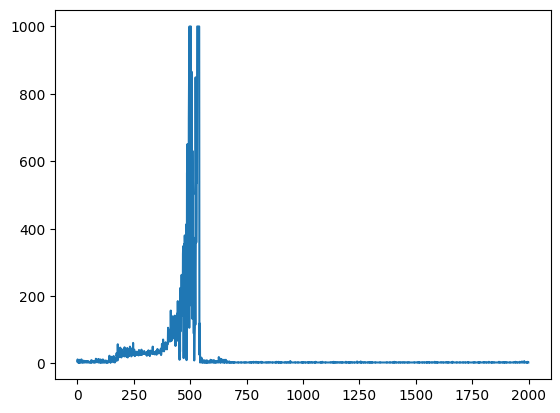

In [11]:
import matplotlib.pyplot as plt
x = np.arange(len(score_history))
plt.plot(x, score_history)